# Basis SQL Operations in Spark SQL

In [1]:
import findspark
findspark.init()

In [13]:
from pyspark.sql import SparkSession

# Membuat Spark session
spark = SparkSession.builder \
    .appName("DataFrameExample") \
    .getOrCreate()
data = [
    ('Vania', 25, 'F', 4000, 1),
    ('Melia', 28, 'F', 4200, 2),
    ('Dewa', 30, 'M', 3000, 1),
    ('Joo', 32, 'M', 3500, 2),
    ('Brayn', 29, 'M', 2800, 2)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()

+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|Vania| 25|     F|  4000|     1|
|Melia| 28|     F|  4200|     2|
| Dewa| 30|     M|  3000|     1|
|  Joo| 32|     M|  3500|     2|
|Brayn| 29|     M|  2800|     2|
+-----+---+------+------+------+

+-----+---+
| Name|Age|
+-----+---+
|Vania| 25|
|Melia| 28|
|  Joo| 32|
+-----+---+

+-----------+
|avg(Salary)|
+-----------+
|     3500.0|
+-----------+



# Advanceed Queries for Data Analisis
1. Cari rata-rata gaji per departemen.

In [3]:
spark.sql('''
SELECT DeptId, AVG(Salary) as AvgSalary
FROM employees
GROUP BY DeptId
ORDER BY DeptId
''').show()


+------+---------+
|DeptId|AvgSalary|
+------+---------+
|     1|   3500.0|
|     2|   3500.0|
+------+---------+



2. Temukan karyawan yang memiliki gaji di atas rata-rata untuk gender masing-masing.

In [4]:
spark.sql('''
SELECT Name, Age, Gender, Salary
FROM employees
WHERE Salary > (
    SELECT AVG(Salary)
    FROM employees e2
    WHERE e2.Gender = employees.Gender
)
''').show()

+-----+---+------+------+
| Name|Age|Gender|Salary|
+-----+---+------+------+
|Melia| 28|     F|  4200|
|  Joo| 32|     M|  3500|
+-----+---+------+------+



3. Buat ranking karyawan berdasarkan gaji dalam departemen mereka.

In [5]:
spark.sql('''
SELECT Name, DeptId, Salary,
       DENSE_RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) AS Rank
FROM employees
ORDER BY DeptId, Rank
''').show()

+-----+------+------+----+
| Name|DeptId|Salary|Rank|
+-----+------+------+----+
|Vania|     1|  4000|   1|
| Dewa|     1|  3000|   2|
|Melia|     2|  4200|   1|
|  Joo|     2|  3500|   2|
|Brayn|     2|  2800|   3|
+-----+------+------+----+



# Penggunaan WIndow Function dan Subqueries

In [6]:
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()

+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|Vania| 25|  4000|   1|
|Melia| 28|  4200|   1|
|Brayn| 29|  2800|   1|
| Dewa| 30|  3000|   1|
|  Joo| 32|  3500|   1|
+-----+---+------+----+



# Advanced Spark SQL Queries

In [7]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('Vania', 25, 'F', 4000, 1),
    ('Melia', 28, 'F', 4200, 2),
    ('Dewa', 30, 'M', 3000, 1),
    ('Joo', 32, 'M', 3500, 2),
    ('Brayn', 29, 'M', 2800, 2)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()

+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
| Dewa| 30|       HR|  Project A|
|Vania| 25|       HR|  Project A|
|Brayn| 29|Marketing|  Project B|
|  Joo| 32|Marketing|  Project B|
|Melia| 28|Marketing|  Project B|
+-----+---+---------+-----------+



1. Tuliskan query SQL untuk menemukan rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji.

In [8]:
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, e.Salary,
       avg_salary.AvgSalary,
       DENSE_RANK() OVER (PARTITION BY e.DeptId ORDER BY e.Salary DESC) AS Rank
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN (
    SELECT DeptId, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY DeptId
) avg_salary ON e.DeptId = avg_salary.DeptId
ORDER BY e.DeptId, Rank
''').show()


+-----+---+---------+------+---------+----+
| Name|Age| DeptName|Salary|AvgSalary|Rank|
+-----+---+---------+------+---------+----+
|Vania| 25|       HR|  4000|   3500.0|   1|
| Dewa| 30|       HR|  3000|   3500.0|   2|
|Melia| 28|Marketing|  4200|   3500.0|   1|
|  Joo| 32|Marketing|  3500|   3500.0|   2|
|Brayn| 29|Marketing|  2800|   3500.0|   3|
+-----+---+---------+------+---------+----+



2. Gunakan window functions untuk menentukan tren gaji berdasarkan usia di setiap departemen.

In [9]:
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, e.Salary,
       AVG(e.Salary) OVER (PARTITION BY e.DeptId ORDER BY e.Age) AS AvgSalaryByAge,
       DENSE_RANK() OVER (PARTITION BY e.DeptId ORDER BY e.Salary DESC) AS SalaryRank
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
ORDER BY e.DeptId, e.Age
''').show()

+-----+---+---------+------+--------------+----------+
| Name|Age| DeptName|Salary|AvgSalaryByAge|SalaryRank|
+-----+---+---------+------+--------------+----------+
|Vania| 25|       HR|  4000|        4000.0|         1|
| Dewa| 30|       HR|  3000|        3500.0|         2|
|Melia| 28|Marketing|  4200|        4200.0|         1|
|Brayn| 29|Marketing|  2800|        3500.0|         3|
|  Joo| 32|Marketing|  3500|        3500.0|         2|
+-----+---+---------+------+--------------+----------+



# Advanced Data Analysis dan Visualisation

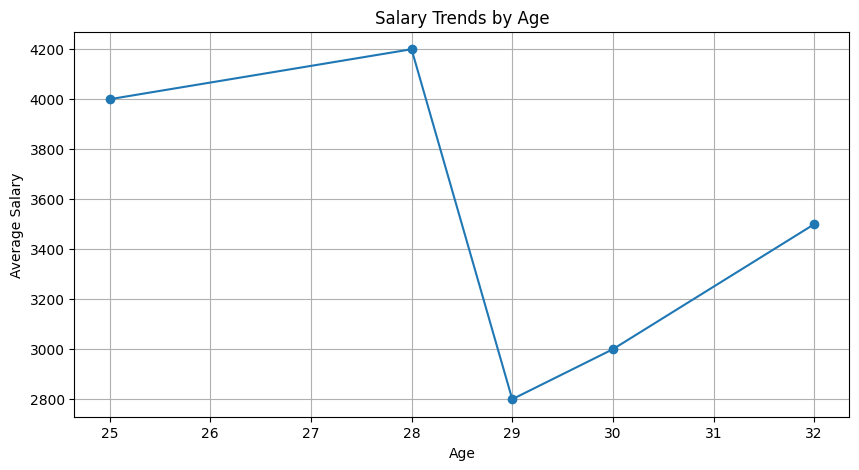

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()

# Homework
1. Gunakan Spark SQL untuk mencari total gaji dan jumlah karyawan per departemen. Buat visualisasi perbandingan antar departemen.

+---------+-----------+-------------+
| DeptName|TotalSalary|EmployeeCount|
+---------+-----------+-------------+
|Marketing|      10500|            3|
|       HR|       7000|            2|
+---------+-----------+-------------+



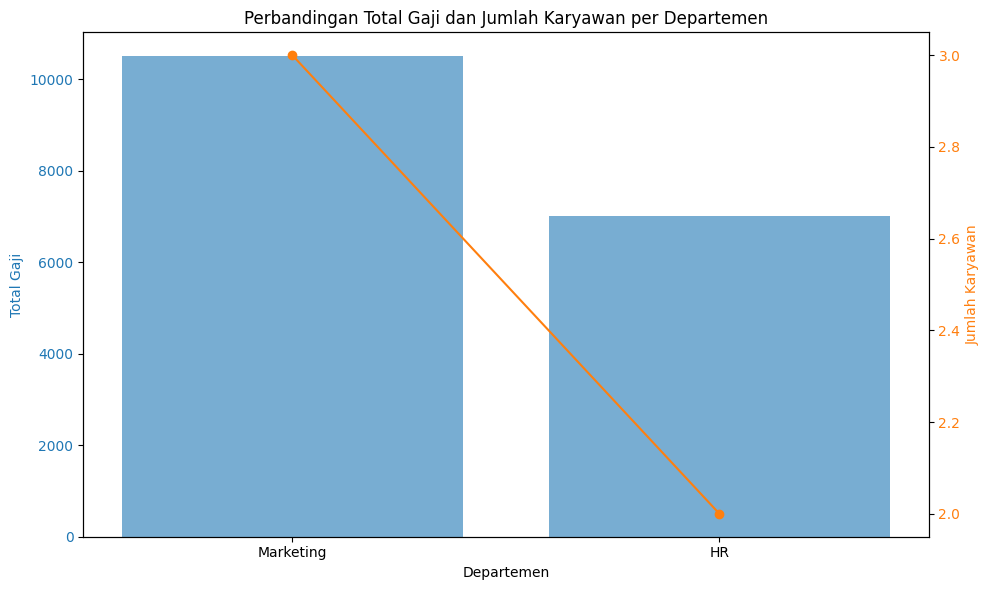

In [11]:
result = spark.sql('''
SELECT d.DeptName, 
       SUM(e.Salary) AS TotalSalary, 
       COUNT(e.Name) AS EmployeeCount
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY TotalSalary DESC
''')

# Menampilkan hasil
result.show()

# Mengonversi hasil ke dalam Pandas DataFrame
pdf = result.toPandas()

# Membuat subplot untuk visualisasi
fig, ax1 = plt.subplots(figsize=(10, 6))

# Membuat grafik batang untuk total gaji
color = 'tab:blue'
ax1.set_xlabel('Departemen')
ax1.set_ylabel('Total Gaji', color=color)
ax1.bar(pdf['DeptName'], pdf['TotalSalary'], color=color, alpha=0.6, label='Total Gaji')
ax1.tick_params(axis='y', labelcolor=color)

# Membuat grafik garis untuk jumlah karyawan
ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('Jumlah Karyawan', color=color)
ax2.plot(pdf['DeptName'], pdf['EmployeeCount'], color=color, marker='o', label='Jumlah Karyawan')
ax2.tick_params(axis='y', labelcolor=color)

# Menambahkan judul dan legenda
plt.title('Perbandingan Total Gaji dan Jumlah Karyawan per Departemen')
fig.tight_layout()  
plt.show()

2.  

+---+-------------+
|Age|AboveAvgCount|
+---+-------------+
+---+-------------+



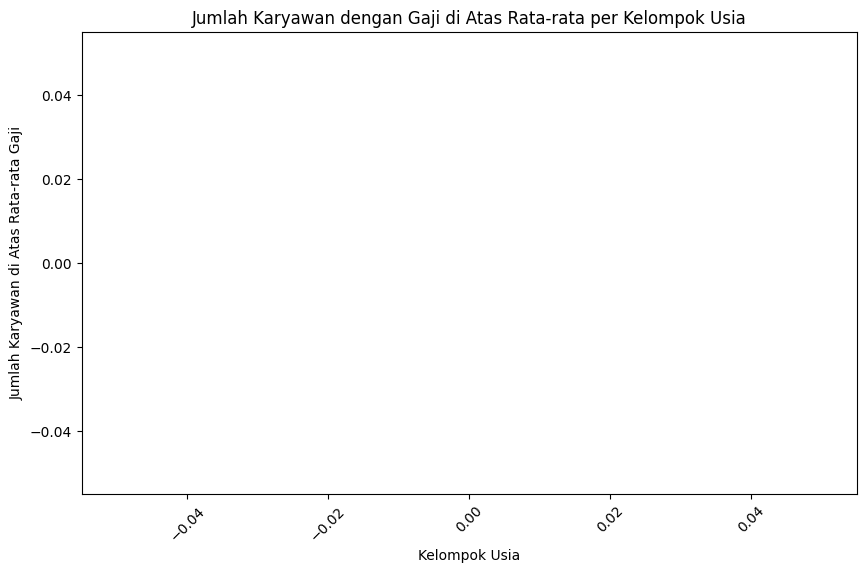

In [12]:
result = spark.sql('''
WITH AvgSalaryByAge AS (
    SELECT Age, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY Age
)
SELECT e.Age, COUNT(e.Name) AS AboveAvgCount
FROM employees e
JOIN AvgSalaryByAge a ON e.Age = a.Age
WHERE e.Salary > a.AvgSalary
GROUP BY e.Age
ORDER BY e.Age
''')

# Menampilkan hasil
result.show()

# Mengonversi hasil ke dalam Pandas DataFrame
pdf = result.toPandas()

# Membuat visualisasi dalam bentuk grafik batang
plt.figure(figsize=(10, 6))
plt.bar(pdf['Age'].astype(str), pdf['AboveAvgCount'], color='skyblue')
plt.xlabel('Kelompok Usia')
plt.ylabel('Jumlah Karyawan di Atas Rata-rata Gaji')
plt.title('Jumlah Karyawan dengan Gaji di Atas Rata-rata per Kelompok Usia')
plt.xticks(rotation=45)
plt.show()